<!--NAVIGATION-->

<a target="_blank" href="https://colab.research.google.com/github/bpesquet/machine-learning-handbook/blob/master/notebooks/models/cnn.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# Convolutional Neural Networks

## Summary

- Architecture
- History
- Training a convnet
- Using a pretrained model

## Architecture

### Justification

The visual world has the following properties:

- Translation invariance.
- Spatial hierarchy: complex and abstract concepts are composed from simple elements.

Classical models are not designed to detect local patterns in images.

### General CNN design

[![General CNN architecture](images/cnn_architecture.png)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

### The convolution operation

Apply a filter or **kernel** to data. Result is called a **feature map**.

[![Convolution with a 3x3 filter of depth 1 applied on 5x5 data](images/convolution_overview.gif)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

![Convolution example](images/convolution_example.jpeg)

### Convolution parameters

- **Filter dimensions**: 2D for images.
- **Filter size**: generally 3x3 or 5x5.
- **Number of filters**: determine the number of feature maps created by the convolution operation.
- **Stride**: step for sliding the convolution window. Generally equal to 1.
- **Padding**: blank rows/columns with all-zero values added on sides of the input feature map.

### Preserving output dimensions with padding

[![Preserving output dimensions with padding](images/2d_convol.gif)](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

### 2D convolutions on 3D tensors

- An image has several color channels.
- Number of channels = filter depth.
- The convolution result is still a scalar.

[![2D convolution on a 32x32x3 image with 10 filters](images/conv_image.png)](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

[![2D convolution over RGB image](images/2D_conv_over_rgb_image.png)](https://stackoverflow.com/a/44628011/2380880)

### Activation function

- Applied to the (scalar) convolution result.
- Introduces non-linearity in the model.
- Standard choice: $ReLU(z) = max(0,z)$

### The pooling operation

- Reduces the dimensionality of feature maps.
- Often done by selecting maximum values (*max pooling*).

[![Max pooling with 2x2 filter and stride of 2](images/maxpool_animation.gif)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

### Pooling output

[![Pooling with a 2x2 filter and stride of 2 on 10 32x32 feature maps](images/maxpooling_image.png)](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

## History

### Humble beginnings: LeNet5 (1993)

![LeNet5](images/lenet5.jpg)

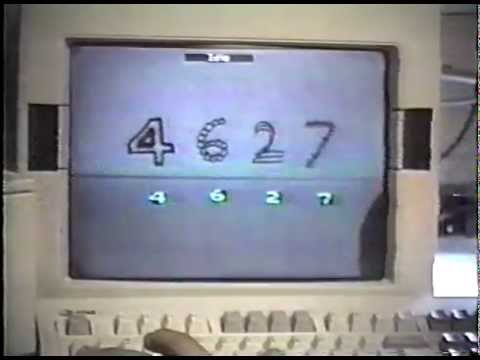

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("FwFduRA_L6Q")

### The breakthrough: ILSVRC

- [_ImageNet Large Scale Visual Recognition Challenge_](http://image-net.org/challenges/LSVRC/)
- Worldwide image classification challenge based on the [ImageNet](http://www.image-net.org/) dataset.

![ILSVRC results](images/ILSVRC_results.jpg)

### AlexNet (2012)

Trained on 2 GPU for 5 to 6 days.

![AlexNet](images/alexnet2.png)

## VGG (2014)

![VGG16](images/vgg16.png)

### GoogLeNet/Inception (2014)

- 9 Inception modules, more than 100 layers.
- Trained on several GPU for about a week.

![Inception](images/google_inception.jpg)

## Microsoft ResNet (2015)

- 152 layers, trained on 8 GPU for 2 to 3 weeks.
- Smaller error rate than a average human.

![ResNet](images/resnet_archi.png)

![Deeper model](images/deeper_model.jpg)

## Training a convnet

### General principle

Same principle as a dense neural network: [backpropagation](https://www.bpesquet.fr/en/slides/ai/neural-networks/) + [gradient descent](https://www.bpesquet.fr/en/slides/ai/ml-fundamentals/).

[Backpropagation In Convolutional Neural Networks](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)


### Data augmentation

Enriching the dataset with new samples created by applying operations on existing ones.

![Data Augmentation](images/data_augmentation.png)

### Example: training a CNN to recognize fashion items

The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains 70,000 28x28 grayscale images of fashion items.

It is slightly more challenging than the ubiquitous MNIST handwritten digits dataset.


### Environment setup

In [4]:
import platform
print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [5]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [39]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.datasets import fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [24]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy
    Takes a Keras History object as parameter"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

In [30]:
# Load the Fashion-MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}. Test labels: {test_labels.shape}")

Training images: (60000, 28, 28). Training labels: (60000,)
Test images: (10000, 28, 28). Test labels: (10000,)


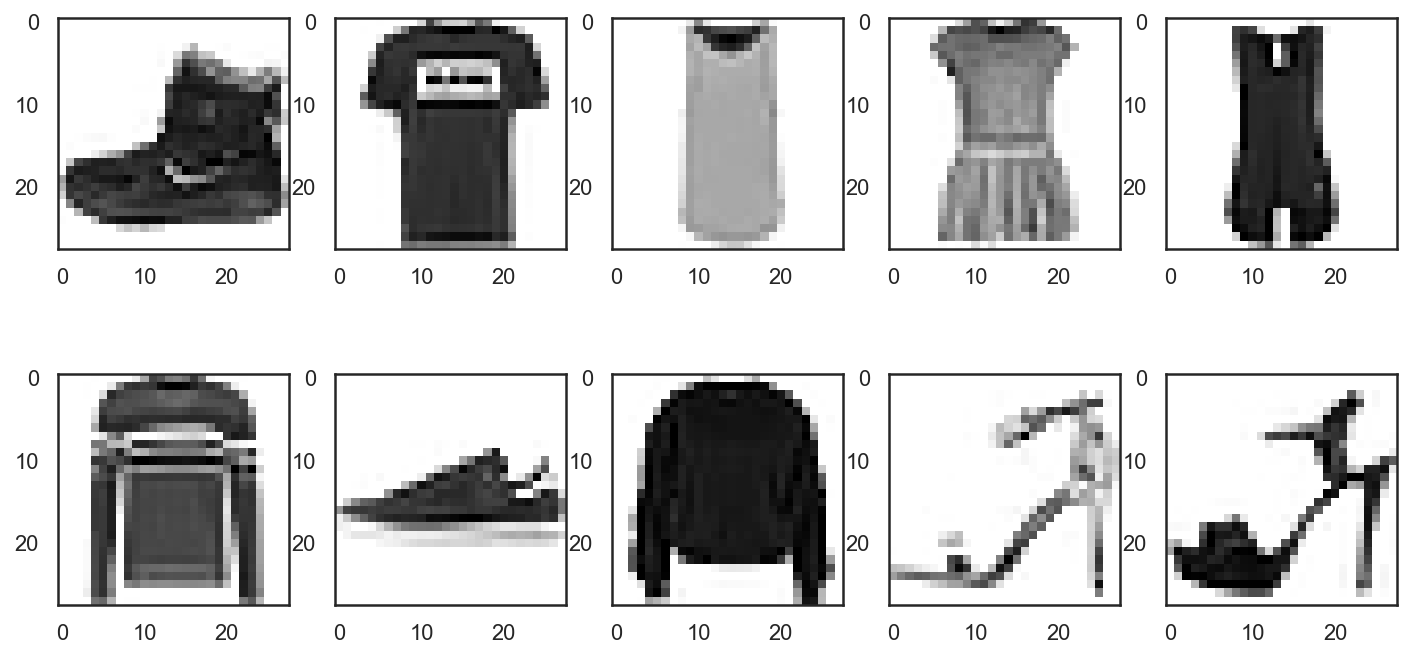

In [9]:
# Plot the first 10 training images
with sns.axes_style('white'): # Temporary hide Seaborn grid lines
    plt.figure(figsize=(12, 6))
    for i in range(10):
        image = train_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap=plt.cm.binary)

In [10]:
# Labels are integer scalars between 0 and 9
df_train_labels = pd.DataFrame(train_labels)
df_train_labels.columns = {'label'}
df_train_labels.sample(n=8)

,label
30989,8
29595,3
28534,6
29816,5
11431,6
26745,6
48197,0
16013,3


### Data preprocessing

In [31]:
# Change pixel values from (0, 255) to (0, 1)
x_train = train_images.astype("float32") / 255
x_test = test_images.astype("float32") / 255

# Make sure images have shape (28, 28, 1) to apply convolution
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encoding of expected results
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}. y_test: {y_test.shape}")

x_train: (60000, 28, 28, 1). y_train: (60000, 10)
x_test: (10000, 28, 28, 1). y_test: (10000, 10)


### Expected model architecture

![Example CNN architecture](images/example_cnn_architecture.png)

In [34]:
# Create a linear stack of layers
cnn_model = Sequential()

# Convolution module 1: Conv2D+MaxPooling2D
#   filters: number of convolution filters
#   kernel_size: size of the convolution kernel (2D convolution window)
#   input_shape: shapre of the input feature map
#   (Here, The expected input shape is a 3D tensor corresponding to an image)
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",input_shape=(28, 28, 1)))
#   pool_size: factors by which to downscale (vertical, horizontal)
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution module 2
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the last output feature map (a 3D tensor) to feed the Dense layer
cnn_model.add(Flatten())
cnn_model.add(Dense(128))
# To fight overfitting
cnn_model.add(Dropout(0.5))
# Classification layer
cnn_model.add(Dense(10, activation="softmax"))

cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               204928    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)             

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 31s 568us/sample - loss: 0.5748 - accuracy: 0.7914 - val_loss: 0.3838 - val_accuracy: 0.8587
Epoch 2/10
54000/54000 [==============================] - 31s 568us/sample - loss: 0.3670 - accuracy: 0.8696 - val_loss: 0.3113 - val_accuracy: 0.8875
Epoch 3/10
54000/54000 [==============================] - 32s 585us/sample - loss: 0.3195 - accuracy: 0.8857 - val_loss: 0.2963 - val_accuracy: 0.8923
Epoch 4/10
54000/54000 [==============================] - 31s 566us/sample - loss: 0.2912 - accuracy: 0.8951 - val_loss: 0.2741 - val_accuracy: 0.8973
Epoch 5/10
54000/54000 [==============================] - 29s 541us/sample - loss: 0.2707 - accuracy: 0.9019 - val_loss: 0.2737 - val_accuracy: 0.8963
Epoch 6/10
54000/54000 [==============================] - 30s 549us/sample - loss: 0.2501 - accuracy: 0.9101 - val_loss: 0.2560 - val_accuracy: 0.9072
Epoch 7/10
54000/54000 [=====================

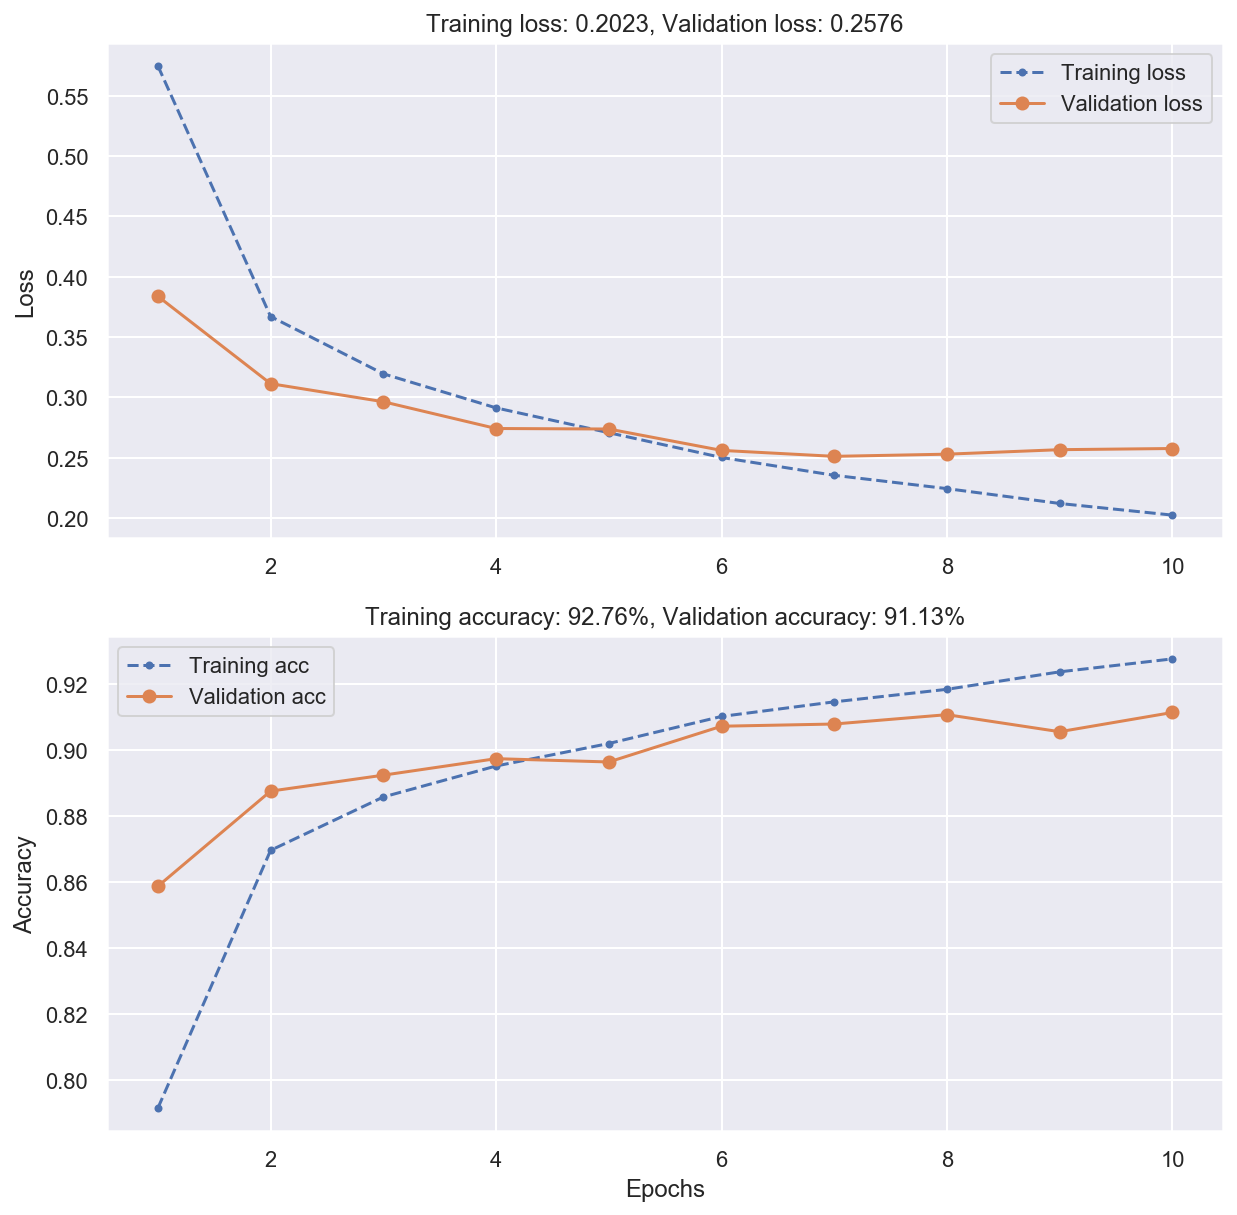

In [35]:
# Preparing the model for training
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model, using 10% of the training set for validation
# (May take several minutes depending on your system)
history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)
plot_loss_acc(history)

In [36]:
# Evaluate model performance on test data
_, test_acc = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy: {test_acc:.5f}')

Test accuracy: 0.90410


### Interpretation

- Convolution layers act as **feature extractors**.
- Dense layers use the extracted features to classify data.

[![Feature extraction with a CNN](images/representation_learning.png)](https://harishnarayanan.org/writing/artistic-style-transfer/)

[Visualizing convnet layers on MNIST](https://transcranial.github.io/keras-js/#/mnist-cnn)

[![Another visualization of intermediate layers on MNIST](images/conv_all_mnist.png)](http://scs.ryerson.ca/~aharley/vis/conv/flat.html)

## Using a pretrained model

### An efficient strategy

A *pretrained model* is a saved network that was previously trained on a large dataset (typically on a large-scale image classification task).

If the training set was general enough, it can act as a generic model and its features can be useful for many problems.

### Feature extraction

Reuse the convolution base of a pretrained model, and add a custom classifier on top ot if.

State-of-the-art models (VGG, ResNet, Inception...) are regularly published by top AI institutions.

### Example: using a pretrained convnet to recognize common objects

The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. The classes are completely mutually exclusive. 

There are 50,000 training images and 10,000 test images.

In [41]:
# Load the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}. Test labels: {test_labels.shape}")

Training images: (50000, 32, 32, 3). Training labels: (50000, 1)
Test images: (10000, 32, 32, 3). Test labels: (10000, 1)


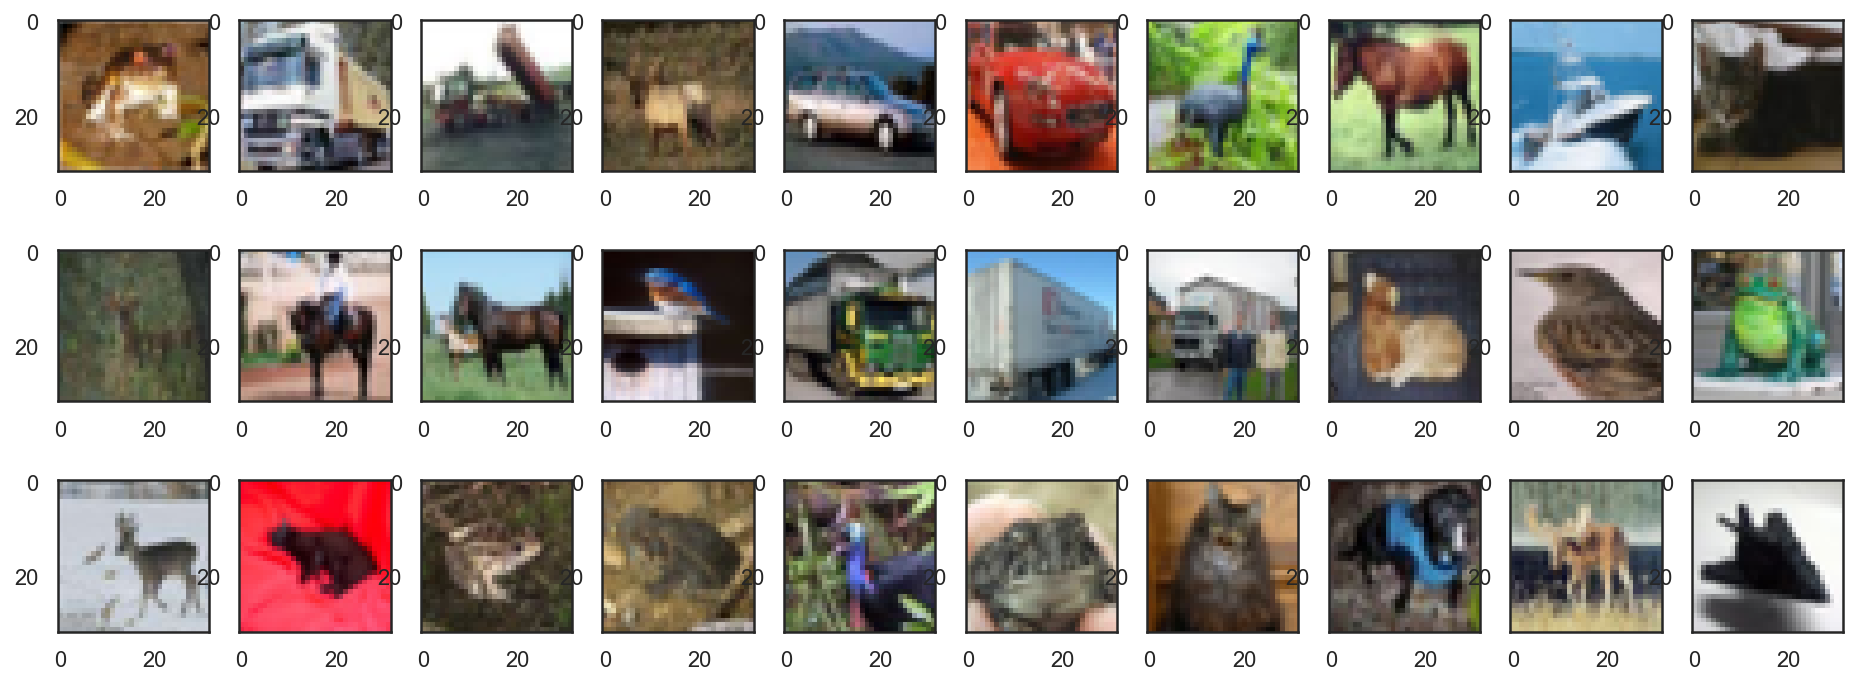

In [42]:
# Plot the first training images
with sns.axes_style('white'):  # Temporary hide Seaborn grid lines
    plt.figure(figsize=(16, 6))
    for i in range(30):
        image = train_images[i]
        fig = plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap=plt.cm.binary)

In [51]:
# Change pixel values from (0, 255) to (0, 1)
x_train = train_images.astype("float32") / 255
x_test = test_images.astype("float32") / 255

# One-hot encoding of expected results
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}. y_test: {y_test.shape}")

x_train: (50000, 32, 32, 3). y_train: (50000, 10)
x_test: (10000, 32, 32, 3). y_test: (10000, 10)


In [52]:
# Using the convolutional base of VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

# Freezing the convolutional base
# This prevents weight updates during training
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [55]:
# Create our new model
pretrained_cnn_model = Sequential()
# Add VGG as its base
pretrained_cnn_model.add(conv_base)
# Add a Dense classifier on top of the pretrained base 
pretrained_cnn_model.add(Flatten())
pretrained_cnn_model.add(Dense(256, activation='relu'))
pretrained_cnn_model.add(Dropout(0.5))
pretrained_cnn_model.add(Dense(10, activation='softmax'))

pretrained_cnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Preparing the model for training
pretrained_cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model, using 10% of the training set for validation
# (May take several minutes depending on your system)
history = pretrained_cnn_model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)
plot_loss_acc(history)

In [ ]:
# Evaluate model performance on test data
_, test_acc = pretrained_cnn_model.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy: {test_acc:.5f}')